In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

import nest_asyncio
nest_asyncio.apply()

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

# tff.federated_computation(lambda: 'Hello, World!')()

In [2]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [3]:
len(emnist_train.client_ids)

3383

In [4]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [5]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

5

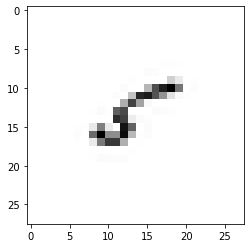

In [6]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

In [7]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [8]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[6],
                     [7],
                     [8],
                     [9],
                     [4],
                     [9],
                     [7],
                     [4],
                     [7],
                     [4],
                     [3],
                     [3],
                     [6],
                     [2],
                     [7],
                     [3],
                     [7],
                     [0],
                     [8],
                     [5]], dtype=int32))])

In [9]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [10]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [11]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [12]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [13]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [15]:
state = iterative_process.initialize()

In [16]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.11255144327878952,loss=3.123215913772583,keras_training_time_client_sum_sec=0.0>


In [17]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.13477365672588348,loss=3.001572847366333,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.14835390448570251,loss=2.8244476318359375,keras_training_time_client_sum_sec=0.0>
round  4, metrics=<sparse_categorical_accuracy=0.15925925970077515,loss=2.8203494548797607,keras_training_time_client_sum_sec=0.0>
round  5, metrics=<sparse_categorical_accuracy=0.19156378507614136,loss=2.545574903488159,keras_training_time_client_sum_sec=0.0>
round  6, metrics=<sparse_categorical_accuracy=0.21111111342906952,loss=2.5024778842926025,keras_training_time_client_sum_sec=0.0>
round  7, metrics=<sparse_categorical_accuracy=0.22860082983970642,loss=2.355034112930298,keras_training_time_client_sum_sec=0.0>
round  8, metrics=<sparse_categorical_accuracy=0.26687243580818176,loss=2.2404472827911377,keras_training_time_client_sum_sec=0.0>
round  9, metrics=<sparse_categorical_accuracy=0.3127571940422058,loss=2.1505444049835

In [18]:
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()